<a href="https://colab.research.google.com/github/hellodoksa/machine-learning-Project/blob/master/KerasDeeplearning_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN 알고리즘 (DCGAN)
- 생성자 : 가짜를 만드는 파트 
  - 랜덤한 픽셀 값으로 채워진 가짜 이미지로 시작해서 판별자의 판별 결과에 따라 지속적으로 업데이트 하며 원하는 이미지를 생성한다. 
  - DCGAN은 CNN을 이용하여 생성 
  - Optimizer를 사용하는 최적화 과정이나 컴파일 하는 과정이 없음.
  - Pooling이 없고 Padding이 존재 : 판별자가 비교할 '진짜'와 같은 크기가 되어야하기 때문 
  - 배치 정규화 : 입력 데이터의 평균이 0, 분산이 1이 되도록 재배치 , 다음층으로 입력될 값을 일정하게 재배치 하는 여활 ,
  - 이 과정을 통해 층의 개수가 늘어나도 안정적으로 학습할 수 있음 (BatchNormalization() 함수 존재 )
  -생성자의 활성화 함수는 ReLU()를 사용하고 판별자로 넘겨 주기 직전에 tanh() 함수를 사용. 

- 판별자 : 진위를 가려내는 파트 
  - 생성자에서 넘어온 이미지가 가짜인지 진짜인지 판별해 주는 장치 
  - CNN의 구조를 그대로 가져와서 만드면 됨 
  - 진짜(1) 아니면 가짜(0) 둘 중 하나를 결정하는 문제 (binary_crossentropy , adam을 사용 )
  - 판별자는 단지 진짜인지 가짜인지 판별만 해줄 뿐, 자기 자신이 학습을 해서는 안된다. 
  - 판별자가 얻은 가중치는 판별자 자신이 학습하는데 쓰이는게 아니라 생성자로 넘겨주어 생성자가 업데이트 된 이미지를 만들도록 해야한다. 
  - 가중치를 저장하는 학습 기능을 꺼야한다. 

- 적재적 신경망 실행하기 
  - 생성자와 판별자를 연결시키고 학습을 진행
  - 생성자와 판별자를 연결시킨다는 것 -> 생성자에서 나온 출력을 판별자에 넣어서 진위 여부를 판별하게 만든다. 
  - 생성사 G()에 입력값 input을 넣은 결과는 G(input) , 판별자 D( )에 넣은 결과는 D(G(input))이 된다. 
  - 판별자(D)는 실제 데이터인 x로 만든 D(x)만 참이라고 여긴다. 
  - 그러나 D(G(input)과 D(x)를 판별자가 더는 구별하지 못하게 되어 정확도가 0.5에 가까워질 때, 비로소 생성자는 자신의 역활을 다하게 되어 학습이 종료됨  

In [0]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten,Dropout
from tensorflow.keras.layers import BatchNormalization , Activation , LeakyReLU, UpSampling2D , Conv2D
from tensorflow.keras.models import Sequential,Model 
import numpy as np
import matplotlib.pyplot as plt

In [0]:
### 생성자 만들기 
generator =Sequential()

#128은 임의로 정한 노드의 수 / Input_dim : 100차원 크기의 랜덤벡터를 준비해라
#Upsampling을 두번해서 28x28이 되야하니 7*7로 시작하자
#작은 크기의 이미지를 점점 늘려가면서 CNN을 지나게 하는것이 DCGAN의 특징이다.
generator.add(Dense(128*7*7 , input_dim = 100 , activation = LeakyReLU(0.2)))

generator.add(BatchNormalization())  # 데이터를 정규분포로 배치 정규화 진행 

# CNN layer가 받아들일 수 있는 형태로 바꿔준다.
# Conv2D 함수의 input_shape 부분에 들어갈 형태로 정해줌 
generator.add(Reshape((7,7,128)))

# 첫번째 upsampling을 한 후 컨볼루션 과정 진행. 
generator.add(UpSampling2D()) 
generator.add(Conv2D(64, kernel_size=5 , padding='same'))
generator.add(BatchNormalization())  # 데이터를 정규분포로 배치 정규화 진행 
generator.add(Activation(LeakyReLU(0.2)))

# 두번째 upsampling을 한 후 컨볼루션 과정 진행.
# 컨볼루션 과정을 판별자로 값을 넘길 준비를 마친다. 
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding="same",activation='tanh'))


In [0]:
### 생성자 만들기 
## 노드 수는 64,128,  5x5 마스크를 사용
## stride를 사용하는 이유 : 가로 세로 크기가 더 줄어들어 dropout , pooling 처럼 새로운 특징을 뽑아준다. 
## 생성자는 출력 수를 28로 맞춰야해서 크기를 늘렸지만 생성자는 그럴필요가 없따!!!
discriminator =Sequential()

discriminator.add(Conv2D(64, kernel_size= 5 , strides =2, input_shape = (28,28,1), padding="same")) ## stride : 마스크를 몇 칸씩 이동 시킬지
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))

discriminator.add(Conv2D(128, kernel_size=5, strides=2,padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())  # 2차원으로 진행된 과정을 1차원으로 바꿔줌 

discriminator.add(Dense(1, activation='sigmoid')) # 판별 결과가 진실(0) , 거짓(1)으로 나와야 하기 때문에 sigmoid함수를 사용
discriminator.compile(loss='binary_crossentropy',optimizer='adam')
discriminator.trainable = False # 자신이 학습 되지 않게끔 학습 기능을 끈다. 

In [0]:
### 생성자와 판별자 모델을 연결 시키는 GAN 모델 만들기 

# 랜덤한 100개의 벡터를 케라스 input 함수에 넣어 생성자에 입력할 ginput으로 만든다.
ginput = Input(shape=(100,))

# 생성자 모델 generator에 ginput을 입력한다. 
# 그 결과 출력되는 28*28 크기의 이미지가 그대로 판별자 dscriminator 입력으로 들어간다. 
dis_output = discriminator(generator(ginput)) 

#케라스의 Model 함수를 이용하여 ginput값과 dis_output 값을 넣어 gan이라는 새로운 모델을 생성한다.
gan = Model(ginput,dis_output)

# 참과 거짓을 구분하는 이진 로스 함수와 최적화 함수(adam)을 사용해 gan 모델을 컴파일 한다. 
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_10 (Sequential)   (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_11 (Sequential)   (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [0]:
## 신경망을 실행시키는 함수 만들기 
# saving_interval : 중간 과정을 저장할 때 몇번마다 한번씩 저장할지 
def gan_train(epoch,batch_size, saving_interval) :
  
  # MNIST 데이터 불러오기 
  # 테스트 과정은 필요 없고 이미지만 사용할 것이기 때문에 x_train만 호출
  (x_train , _) , (_ , _) = mnist.load_data()
  x_train = x_train.reshape(x_train.shape[0],28,28,1).astype('float32')

  # 앞서 생성자에서 값을 -1 ~ 1사이 값으로 지정하기 위해 tanh를 사용함 
  # 따라서 mnist 값도 맞춰주기 위해 127.5를 빼준 뒤, 127.5로 나눠서 -1 ~ 1사이의 값으로 바꿈 
  x_train = (x_train - 127.5) / 127.5

  # batch_size 만큼 Mnist 손글씨 이미지를 랜덤하게 불러와 판별자에 넣는 과정 
  # 실제 이미지를 입력했으므로 모두 참(1)이라는 레이블을 붙인다. 
  true = np.ones((batch_size , 1))
  # 가짜 이미지를 입력했으므로 모두 거짓(0)이라는 레이블을 붙인다. 
  fake = np.zeros((batch_size ,1))

  for i in range(epoch) :
    # 실제 데이터를 판별자에 입력 

    #random.randint (a,b,c) : a에서 b까지의 숫자 중 하나를 랜덤하게 선택해 가져오는 과정을 c번 반복
    idx = np.random.randint(0,x_train.shape[0],batch_size)
    imgs= x_train[idx]

    #train_on_batch : 입력값(x)과 레이블(y)을 받아서 한 번 학습을 실시해 모델을 업데이트 한다. 
    d_loss_real = discriminator.train_on_batch(imgs,true)

    # 가상 이미지를 판별자에 입력 
    noise = np.random.normal( 0 ,1,(batch_size , 100))
    gen_imgs = generator.predict(noise)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

    # 판별자와 생성자의 오차 계산 
    d_loss = 0.5 * np.add(d_loss_real,d_loss_fake)
    g_loss = gan.train_on_batch(noise , true)

    print('epoch:%d' %i , 'd_loss : %.4f'%d_loss ,'g_loss : %.4f'%g_loss )

    ## 이미지 저장한다. 
    if i % saving_interval == 0 :
      print ('epoch:%d' %i , '== %d' %i)
      noise = np.random.normal(0,1,(25,100))
      gen_imgs = generator.predict(noise)

      # rescale img 
      gen_imgs = 0.5 * gen_imgs + 0.5

      fig, axs = plt.subplots(5,5,sharey=True)
      count = 0 
      for j in range(5) : 
        for k in range(5) :
          axs[j,k].imshow(gen_imgs[count, :,:,0],cmap = 'gray')
          axs[j,k].axis('off')
          count += 1

epoch:0 d_loss : 0.6533 g_loss : 0.0448
epoch:0 == 0
epoch:1 d_loss : 0.5695 g_loss : 0.1453
epoch:2 d_loss : 0.4783 g_loss : 0.4165
epoch:3 d_loss : 0.5034 g_loss : 0.6457
epoch:4 d_loss : 0.5430 g_loss : 0.6549
epoch:5 d_loss : 0.5132 g_loss : 0.6261
epoch:6 d_loss : 0.4597 g_loss : 0.6436
epoch:7 d_loss : 0.3914 g_loss : 0.7378
epoch:8 d_loss : 0.3482 g_loss : 0.9875
epoch:9 d_loss : 0.2647 g_loss : 1.4377
epoch:10 d_loss : 0.2232 g_loss : 2.0252
epoch:11 d_loss : 0.2799 g_loss : 2.2159
epoch:12 d_loss : 0.5165 g_loss : 2.0404
epoch:13 d_loss : 0.7374 g_loss : 1.5012
epoch:14 d_loss : 0.7018 g_loss : 1.5501
epoch:15 d_loss : 0.7318 g_loss : 1.1068
epoch:16 d_loss : 0.6410 g_loss : 1.0966
epoch:17 d_loss : 0.6356 g_loss : 1.0616
epoch:18 d_loss : 0.4939 g_loss : 0.9237
epoch:19 d_loss : 0.5316 g_loss : 0.7263
epoch:20 d_loss : 0.4654 g_loss : 0.7301
epoch:21 d_loss : 0.4308 g_loss : 0.8130
epoch:22 d_loss : 0.3975 g_loss : 0.9173
epoch:23 d_loss : 0.4418 g_loss : 0.9266
epoch:24 d_lo

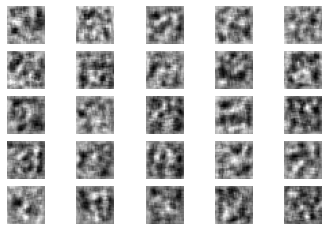

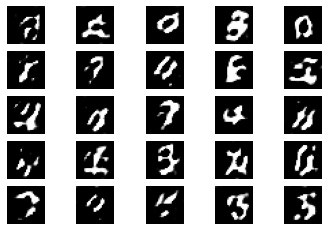

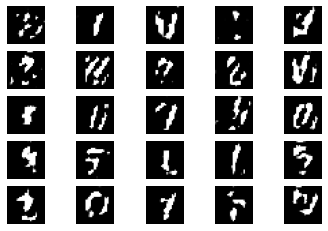

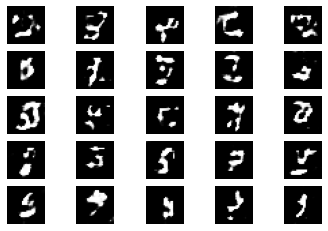

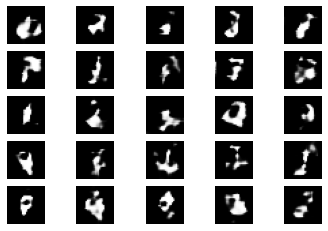

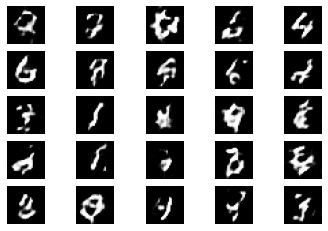

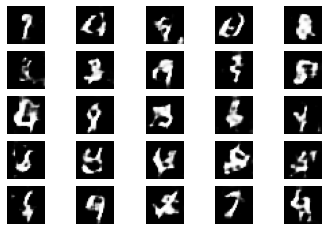

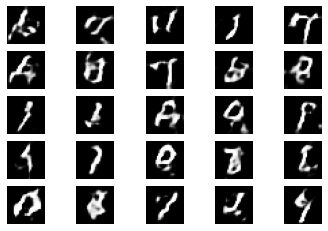

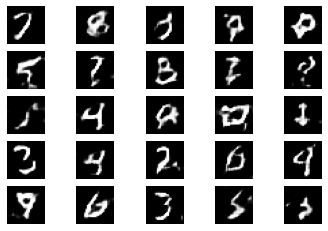

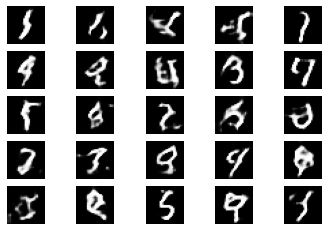

In [0]:

gan_train(2000,32,200)
